# Load packages

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
# System libraries
import os
import configparser

#Standard libraries
import numpy as np 
import geopandas as gpd
import xarray as xr

#For geometries
from shapely import box, Polygon

#For plotting, ticking, and line collection
import matplotlib.pylab as plt

# Specify the region, load and parse single shape file

In [27]:
# Path to ini file
ini = 'config/ATL15.ini'

######## Load variables ###########

# Create a ConfigParser object
config = configparser.ConfigParser()

# Read the configuration file
config.read(ini)

#os and pyproj paths
gdal_data = config.get('os', 'gdal_data')
proj_lib = config.get('os', 'proj_lib')
proj_data = config.get('os', 'proj_data')

#path params
shape = f'shapes/scripps_antarctic_polygons_CR.shp'
output_dir = config.get('data', 'output_dir')
rema_path = config.get('data', 'rema_path')
try: plot_dir = config.get('data', 'plot_dir')
except: plot_dir='plots'

#Edit path to projections
os.environ["GDAL_DATA"] = gdal_data # need to specify to make gdal work
os.environ["PROJ_LIB"] = proj_lib # need to specify to make pyproj work
os.environ["PROJ_DATA"] = proj_data # need to specify to make pyproj work

print('Projection paths: gdal and pyproj')
print(f'{gdal_data}')
print(f'{proj_lib}')
print(f'{proj_data}')

print(f"output_dir: {output_dir}")

Projection paths: gdal and pyproj
/usr/local/Caskroom/miniconda/base/envs/fresh/share/gdal
/usr/local/Caskroom/miniconda/base/envs/fresh/share/proj
/usr/local/Caskroom/miniconda/base/envs/fresh/share/proj
output_dir: /Volumes/nox2/Chance/data/is2/ATL15/


# Make Shapes

<Axes: >

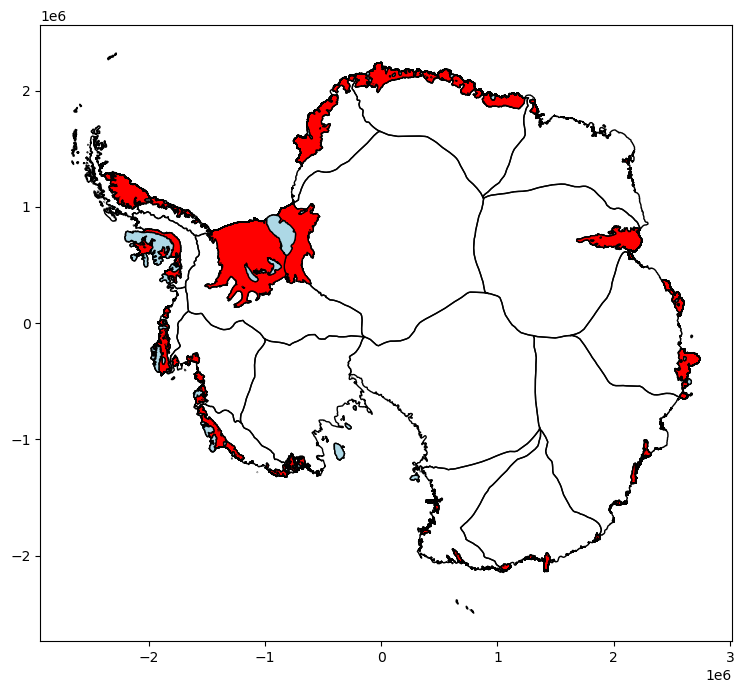

In [22]:
#Make shapes
####
crs_antarctica = 'EPSG:3031'
crs_latlon = 'EPSG:4326'
short_name = 'ATL15'
# Read shapefile into gdf for everything
gdf = gpd.read_file(shape).set_crs(crs_latlon, allow_override=True).to_crs(crs_antarctica)

# Separate by entry type
gdf_fl = gdf[gdf.Id_text=='Ice shelf']
gdf_pp = gdf[(gdf.Id_text=='Ice rise or connected island')]
gdf_ext = gpd.GeoDataFrame(geometry=[gdf_fl.apply(lambda p: Polygon(p.geometry.exterior.coords), axis=1).unary_union.union(gdf_pp.unary_union)],
    crs=crs_antarctica).explode(ignore_index=True)
gdf_gr = gdf[gdf.Id==1]
gdf_ext_all = gpd.GeoDataFrame(geometry=[gdf_ext.unary_union.union(gdf_gr.unary_union)], crs=crs_antarctica)

# gdf for subsetting
#gdf = gdf[~(gdf.Id==1)]
#gdf = gpd.GeoDataFrame(geometry=[gdf.unary_union], crs=crs_antarctica)
#gdf = gdf.

# plot the geometries
fig1, ax1 = plt.subplots(figsize=[10, 8])
#gdf.convex_hull.plot(ax=ax1, color='None', edgecolor='black')
gdf.plot(ax=ax1, color='none', edgecolor='black')
gdf_ext.plot(ax=ax1, color='yellow', edgecolor='black')
gdf_fl.plot(ax=ax1, color='red', edgecolor='black')
gdf_pp.plot(ax=ax1, color='lightblue', edgecolor='black')

# Functions

In [4]:
def clean_encoding(dataset):
    '''
    Cleans encoding by removing invalid keys and ensuring that they are the right datatype
    '''
    encoding = {}
    valid_encoding_items = ['endian', 'szip_pixels_per_block', 'shuffle', 
        'fletcher32', 'quantize_mode', 'blosc_shuffle', 'contiguous', 'significant_digits', 'compression', 
        'least_significant_digit', 'szip_coding', 'zlib', '_FillValue', 'dtype', 'complevel']
    valid_encoding_items = ['least_significant_digit']
    
    #dataset['time'].encoding.update({'dtype': 'datetime64[ns]'})
    
    for var in dataset.data_vars:
        # set least_significant_digit to 4 and remove source (in case the devs are using it to overwrite my encoding)
        if 'least_significant_digit' in dataset[var].encoding:
            dataset[var].encoding['least_significant_digit']=4
        if 'source' in dataset[var].encoding:
            dataset[var].encoding['source']=None
        # add only valid encoding items
        encoding[var] = {key: value for key, value in dataset[var].encoding.items() if key in valid_encoding_items}
    return encoding

# Load, process, and save the data

## ATL14

In [11]:
filename_a4_14 = f'{output_dir}/../ATL14/ATL14_A4_0321_100m_004_01.nc'
filename_a1_14 = f'{output_dir}/../ATL14/ATL14_A1_0321_100m_004_01.nc'
processed_out_dir='/Volumes/nox2/Chance/processed_data'

a1_14 = xr.open_dataset(filename_a1_14)
a4_14 = xr.open_dataset(filename_a4_14)

# Just in case
# I dont process or save these because they don't suit my use case

## ATL15

In [15]:
filename_a4 = f'{output_dir}/ATL15_A4_0321_01km_004_01.nc'
filename_a1 = f'{output_dir}/ATL15_A1_0321_01km_004_01.nc'
processed_out_dir='/Volumes/nox2/Chance/processed_data'

# Load and combine ATL15 regions
# Generate encoding (they should all be identical anyway)
a1_dhdt_lag1 = xr.open_dataset(filename_a1, group='/dhdt_lag1/')
a4_dhdt_lag1 = xr.open_dataset(filename_a4, group='/dhdt_lag1/')
ae_dhdt_lag1 = xr.combine_by_coords([a1_dhdt_lag1, a4_dhdt_lag1], data_vars=['dhdt', 'dhdt_sigma', 'ice_area'])

a1_dhdt_lag4 = xr.open_dataset(filename_a1, group='/dhdt_lag4/')
a4_dhdt_lag4 = xr.open_dataset(filename_a4, group='/dhdt_lag4/')
ae_dhdt_lag4 = xr.combine_by_coords([a1_dhdt_lag4, a4_dhdt_lag4], data_vars=['dhdt', 'dhdt_sigma', 'ice_area'])

a1_dhdt_lag20 = xr.open_dataset(filename_a1, group='/dhdt_lag20/')
a4_dhdt_lag20 = xr.open_dataset(filename_a4, group='/dhdt_lag20/')
ae_dhdt_lag20 = xr.combine_by_coords([a1_dhdt_lag20, a4_dhdt_lag20], data_vars=['dhdt', 'dhdt_sigma', 'ice_area'])

a1_dh = xr.open_dataset(filename_a1, group='/delta_h/')
a4_dh = xr.open_dataset(filename_a4, group='/delta_h/')
ae_dh = xr.combine_by_coords([a1_dh, a4_dh], data_vars=['delta_h', 'delta_h_sigma', 'ice_area'])

# Need to clean the encoding because xarray and 
encoding_ae_dhdt_lag1 = clean_encoding(ae_dhdt_lag1)
encoding_ae_dhdt_lag4 = clean_encoding(ae_dhdt_lag4)
encoding_ae_dhdt_lag20 = clean_encoding(ae_dhdt_lag20)
encoding_ae_dh = clean_encoding(ae_dh)

# Change some attributes so they can be more easily printed onto plots
attr_list = ['long_name', 'short_name', 'units', 'resolution']
ae_dhdt_lag1.dhdt.attrs[attr_list[0]], ae_dhdt_lag1.dhdt.attrs[attr_list[1]], ae_dhdt_lag1.dhdt.attrs[attr_list[2]], ae_dhdt_lag1.dhdt.attrs[attr_list[3]] = 'Quarterly dh/dt', 'dhdt_lag1', 'm yr$^{{-1}}$', '1 km'
ae_dhdt_lag4.dhdt.attrs[attr_list[0]], ae_dhdt_lag4.dhdt.attrs[attr_list[1]], ae_dhdt_lag4.dhdt.attrs[attr_list[2]], ae_dhdt_lag4.dhdt.attrs[attr_list[3]] = 'Annual dh/dt', 'dhdt_lag4', 'm yr$^{{-1}}$', '1 km'
ae_dhdt_lag20.dhdt.attrs[attr_list[0]], ae_dhdt_lag20.dhdt.attrs[attr_list[1]], ae_dhdt_lag20.dhdt.attrs[attr_list[2]], ae_dhdt_lag20.dhdt.attrs[attr_list[3]] = 'Pentennial dh/dt', 'dhdt_lag20', 'm yr$^{{-1}}$', '1 km'
ae_dh.delta_h.attrs[attr_list[0]], ae_dh.delta_h.attrs[attr_list[1]], ae_dh.delta_h.attrs[attr_list[2]], ae_dh.delta_h.attrs[attr_list[3]] = 'Height Change', 'delta_h', 'm', '1 km'

# Save all processed dataframes as groups in the same ATL15 netCDF file
ae_dhdt_lag1.to_netcdf(f'{processed_out_dir}/ATL15_AE.nc', mode='w', format="NETCDF4", group='/dhdt_lag1/', encoding=encoding_ae_dhdt_lag1)
ae_dhdt_lag4.to_netcdf(f'{processed_out_dir}/ATL15_AE.nc', mode='a', format="NETCDF4", group='/dhdt_lag4/', encoding=encoding_ae_dhdt_lag4)
ae_dhdt_lag20.to_netcdf(f'{processed_out_dir}/ATL15_AE.nc', mode='a', format="NETCDF4", group='/dhdt_lag20/', encoding=encoding_ae_dhdt_lag20)
ae_dh.to_netcdf(f'{processed_out_dir}/ATL15_AE.nc', mode='a', format="NETCDF4", group='/delta_h/', encoding=encoding_ae_dh)


### Make bounding boxes

In [16]:
# Load the dataset again

filename_a4 = f'{output_dir}/ATL15_A4_0321_01km_004_01.nc'
filename_a1 = f'{output_dir}/ATL15_A1_0321_01km_004_01.nc'
shape_out_dir='/Volumes/nox2/Chance/processed_data'

a1_dhdt_lag20 = xr.open_dataset(filename_a1, group='/dhdt_lag20/')
a4_dhdt_lag20 = xr.open_dataset(filename_a4, group='/dhdt_lag20/')
ae_dhdt_lag20 = xr.combine_by_coords([a1_dhdt_lag20, a4_dhdt_lag20], data_vars=['dhdt', 'dhdt_sigma', 'ice_area'])

In [17]:
# Make a bounding box with zero buffer around the data
# Not the same bounds as indicated in 

a1_min_x, a1_min_y, a1_max_x, a1_max_y = float(a1_dhdt_lag20.x.min().values), float(a1_dhdt_lag20.y.min().values), float(a1_dhdt_lag20.x.max().values), float(a1_dhdt_lag20.y.max().values)
a4_min_x, a4_min_y, a4_max_x, a4_max_y = float(a4_dhdt_lag20.x.min().values), float(a4_dhdt_lag20.y.min().values), float(a4_dhdt_lag20.x.max().values), float(a4_dhdt_lag20.y.max().values)
ae_min_x, ae_min_y, ae_max_x, ae_max_y = float(ae_dhdt_lag20.x.min().values), float(ae_dhdt_lag20.y.min().values), float(ae_dhdt_lag20.x.max().values), float(ae_dhdt_lag20.y.max().values)

a1_bbox = box(a1_min_x, a1_min_y, a1_max_x, a1_max_y)
a4_bbox = box(a4_min_x, a4_min_y, a4_max_x, a4_max_y)
ae_bbox = box(ae_min_x, ae_min_y, ae_max_x, ae_max_y)

gdf_a1 = gpd.GeoDataFrame(geometry=[a1_bbox], crs=crs_antarctica)
gdf_a4 = gpd.GeoDataFrame(geometry=[a4_bbox], crs=crs_antarctica)
gdf_ae = gpd.GeoDataFrame(geometry=[ae_bbox], crs=crs_antarctica)

In [18]:
# Save them
gdf_a1.to_file('shapes/ATL15_A1_bbox.shp')
gdf_a4.to_file('shapes/ATL15_A4_bbox.shp')
gdf_ae.to_file('shapes/ATL15_AE_bbox.shp')

### Extras

In [40]:
# view encodings

data = ae_dh

print("Encodings for variables:")
for var_name in data.data_vars:
    encoding = data[var_name].encoding
    print(f"Variable: {var_name}")
    print(f"Encoding: {encoding}")
    print(f"Raw Encoding: {data[var_name].encoding}\n")  # To see raw encoding if needed

# Loop through coordinates to see their encodings
print("Encodings for coordinates:")
for coord_name in data.coords:
    encoding = data.coords[coord_name].encoding
    print(f"Coordinate: {coord_name}")
    print(f"Encoding: {encoding}")
    print(f"Raw Encoding: {data.coords[coord_name].encoding}\n")  # To see raw encoding if needed


Encodings for variables:
Variable: Polar_Stereographic
Encoding: {}
Raw Encoding: {}

Variable: ice_area
Encoding: {'dtype': dtype('float32'), 'zlib': True, 'szip': False, 'zstd': False, 'bzip2': False, 'blosc': False, 'shuffle': True, 'complevel': 4, 'fletcher32': False, 'contiguous': False, 'chunksizes': (6, 548, 698), 'preferred_chunks': {'time': 6, 'y': 548, 'x': 698}, 'least_significant_digit': 4, 'source': None, 'original_shape': (21, 2191, 2791), '_FillValue': 3.4028235e+38, 'coordinates': 'time y x'}
Raw Encoding: {'dtype': dtype('float32'), 'zlib': True, 'szip': False, 'zstd': False, 'bzip2': False, 'blosc': False, 'shuffle': True, 'complevel': 4, 'fletcher32': False, 'contiguous': False, 'chunksizes': (6, 548, 698), 'preferred_chunks': {'time': 6, 'y': 548, 'x': 698}, 'least_significant_digit': 4, 'source': None, 'original_shape': (21, 2191, 2791), '_FillValue': 3.4028235e+38, 'coordinates': 'time y x'}

Variable: delta_h
Encoding: {'dtype': dtype('float32'), 'zlib': True, 's